## Multipanel plot with profile for each site

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import xarray as xr
import cmocean
import matplotlib.dates as mdates
import cmocean
# from matplotlib.lines import Line2D
import matplotlib as mpl
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap
# import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import itertools
# from matplotlib import gridspec

##### load ERA5 sea ice concentration data

In [2]:
# import daily averaged sea ice data (flagged data already masked)
seaice_1d_2018to2020 = xr.open_dataset("../Data-cleaning/data/seaice_2018to2020_1d.nc")

In [3]:
## select sea ice data for each grid cell closest to mooring site
ice_KO     = seaice_1d_2018to2020.sel(latitude = 75.75, longitude = -60)
ice_sver   = seaice_1d_2018to2020.sel(latitude = 75.5, longitude = -59)
ice_rink   = seaice_1d_2018to2020.sel(latitude = 76, longitude = -61.25)
ice_fisher = seaice_1d_2018to2020.sel(latitude = 76, longitude = -61.75)

## area-weighted mean of sea ice cover in N Baffin Bay
# select N Baffin bay region
ice_baffinbay = seaice_1d_2018to2020.sel(longitude=slice(-70,-65), latitude=slice(75,73))
# For a rectangular grid the cosine of the latitude is proportional to the grid cell area
weights = np.cos(np.deg2rad(ice_baffinbay.latitude))
weights.name = "weights"
# python will broadcast the weights along the longitude dimension so we need to multiply the weights by len(longitude) to get total sum of all weights values
# sum(weights*observations)/sum(weights)
ice_baffinbay_1d_avg = (ice_baffinbay*weights).sum(dim=['longitude','latitude'])/sum(weights*len(ice_baffinbay.longitude))

##### load glacier length data

In [4]:
# Plot glacier data from Taryn - csv spreadsheet
glacier_seasonal_xl = pd.ExcelFile("../Data-cleaning/data/glacier_data_seasonal.xlsx")

print(glacier_seasonal_xl.sheet_names)
sver_seasonal_df = glacier_seasonal_xl.parse(glacier_seasonal_xl.sheet_names[0])
ko_seasonal_df   = glacier_seasonal_xl.parse(glacier_seasonal_xl.sheet_names[1])
rink_seasonal_df = glacier_seasonal_xl.parse(glacier_seasonal_xl.sheet_names[2])

['Sverdrup', 'Kong Oscar', 'Rink']


In [5]:
rink_terminus_da = xr.DataArray(np.array(rink_seasonal_df['length (km)']), dims=["time"],\
                                coords=dict(time=np.array(rink_seasonal_df.date, dtype='datetime64')))

ko_terminus_da = xr.DataArray(np.array(ko_seasonal_df['length (km)']), dims=["time"],\
                                coords=dict(time=np.array(ko_seasonal_df.date, dtype='datetime64')))

sver_terminus_da = xr.DataArray(np.array(sver_seasonal_df['length (km)']), dims=["time"],\
                                coords=dict(time=np.array(sver_seasonal_df.date, dtype='datetime64')))

##### load ITS_LIVE glacier ice velocity data

In [6]:
rink_vel = pd.read_csv('../Data-cleaning/data/ice_velocity/Rink_LAT76.2397--LON-60.8807.csv')
ko_vel   = pd.read_csv('../Data-cleaning/data/ice_velocity/Kong_Oscar_LAT76.0141--LON-59.7148.csv')
sver_vel = pd.read_csv('../Data-cleaning/data/ice_velocity/Sverdrup_LAT75.6355--LON-58.0119.csv')

In [7]:
rink_vel_ds = xr.Dataset(data_vars=dict(velocity=(["time"],rink_vel["v [m/yr]"]),\
                                        velocity_error=(["time"], rink_vel["v_error [m/yr]"]),\
                                        satellite=(["time"], rink_vel["satellite"])),\
                         coords=dict(time=np.array(rink_vel.mid_date, dtype='datetime64')))

In [8]:
ko_vel_ds = xr.Dataset(data_vars=dict(velocity=(["time"],ko_vel["v [m/yr]"]),\
                                        velocity_error=(["time"], ko_vel["v_error [m/yr]"]),\
                                        satellite=(["time"], ko_vel["satellite"])),\
                         coords=dict(time=np.array(ko_vel.mid_date, dtype='datetime64')))

In [9]:
sver_vel_ds = xr.Dataset(data_vars=dict(velocity=(["time"],sver_vel["v [m/yr]"]),\
                                        velocity_error=(["time"], sver_vel["v_error [m/yr]"]),\
                                        satellite=(["time"], sver_vel["satellite"])),\
                         coords=dict(time=np.array(sver_vel.mid_date, dtype='datetime64')))

In [10]:
# order datasets in chronological time
rink_vel_ds_order = rink_vel_ds.sortby("time")
ko_vel_ds_order   = ko_vel_ds.sortby("time")
sver_vel_ds_order = sver_vel_ds.sortby("time")

In [11]:
# remove 1A and 1B data (select Sentinel 2A, 2B, and Landsat 8)
rink_vel_ds_filter = rink_vel_ds_order.where(np.logical_and(rink_vel_ds_order.satellite!='1A', rink_vel_ds_order.satellite!='1B'))
ko_vel_ds_filter   = ko_vel_ds_order.where(np.logical_and(ko_vel_ds_order.satellite!='1A', ko_vel_ds_order.satellite!='1B'))
sver_vel_ds_filter = sver_vel_ds_order.where(np.logical_and(sver_vel_ds_order.satellite!='1A', sver_vel_ds_order.satellite!='1B'))

In [12]:
# running mean function from ITS_LIVE github repo
def runningMean(
    mid_dates,
    variable,
    minpts,
    tFreq
):
    """
    mid_dates: center dates of `variable` data [datetime64]
    variable: data to be average
    minpts: minimum number of points needed for a valid value, else filled with nan
    tFreq: the spacing between centered averages in Days, default window size = tFreq*2
    """
    tsmin = pd.Timestamp(np.min(mid_dates))
    tsmax = pd.Timestamp(np.max(mid_dates))
    ts = pd.date_range(start=tsmin, end=tsmax, freq=f"{tFreq}D")
    ts = pd.to_datetime(ts).values
    idx0 = ~np.isnan(variable)
    runmean = np.empty([len(ts) - 1, 1])
    runmean[:] = np.nan
    tsmean = ts[0:-1] # times for final running mean data

    t_np = mid_dates.astype(np.int64)

    for i in range(len(ts) - 1):
        idx = (
            (mid_dates >= (ts[i] - np.timedelta64(int(tFreq / 2), "D")))
            & (mid_dates < (ts[i + 1] + np.timedelta64(int(tFreq / 2), "D")))
            & idx0
        )
        if sum(idx) >= minpts:
            runmean[i] = np.mean(variable[idx])
            tsmean[i] = np.mean(t_np[idx])

    tsmean = pd.to_datetime(tsmean).values
    return (runmean, tsmean)

In [13]:
runmean_rink, ts_rink = runningMean(rink_vel_ds_filter.time.values,\
                                    rink_vel_ds_filter.velocity.values,5,30)
runmean_ko, ts_ko = runningMean(ko_vel_ds_filter.time.values,\
                                ko_vel_ds_filter.velocity.values,5,30)
runmean_sver, ts_sver = runningMean(sver_vel_ds_filter.time.values,\
                                    sver_vel_ds_filter.velocity.values,5,30)

##### load ERA5 air-sea heat flux data

In [14]:
# open daily heat dataset
heat_1d_ds = xr.open_dataset("../Data-cleaning/data/era5_1d_2018to2020_73to77N_-56to-68_025025_heat_flux.nc")

In [15]:
# The units are joules per square metre (J m^-2 ). 
# To convert to watts per square metre (W m^-2 ), the accumulated values should be divided by the accumulation period expressed in seconds.
# For the hourly reanalysis, the accumulation period is 1 hour.
# must divide values by 3600 (sec/hr)
# make sign convention positive upwards
Q_net_1d_watts = (heat_1d_ds.ssr/3600 + heat_1d_ds.str/3600 + heat_1d_ds.slhf/3600 + heat_1d_ds.sshf/3600)*(-1)

In [16]:
# isolate heat data at daily resolution for each fjord
Q_net_watts_rink   = Q_net_1d_watts.sel(longitude=-61.25, latitude=76) # rink
Q_net_watts_fisher = Q_net_1d_watts.sel(longitude=-61.75, latitude=76) # fisher
Q_net_watts_ko     = Q_net_1d_watts.sel(longitude=-60, latitude=75.75) # kong oscar
Q_net_watts_sver   = Q_net_1d_watts.sel(longitude=-59, latitude=75.5) # sverdrup

##### load freshwater  data

In [17]:
# load netCDFs
rink_racmo_ds = xr.open_dataset('../Data-cleaning/data/runoff/racmo_freshwater_discharge_Rink_Gletsjer.nc')
# rink_mar_ds = xr.open_dataset('netcdfs/mar_freshwater_discharge_Rink_Gletsjer.nc')

KO_racmo_ds = xr.open_dataset('../Data-cleaning/data/runoff/racmo_freshwater_discharge_Nuussuup_Sermia.nc')
# KO_mar_ds = xr.open_dataset('netcdfs/mar_freshwater_discharge_Nuussuup_Sermia.nc')

sver_racmo_ds = xr.open_dataset('../Data-cleaning/data/runoff/racmo_freshwater_discharge_Sverdrup_Gletsjer.nc')
# sver_mar_ds = xr.open_dataset('netcdfs/mar_freshwater_discharge_Sverdrup_Gletsjer.nc')

##### load mooring data

In [18]:
# open Sverdrup 2019 dataset
file_dir = Path('C:/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L3/2019')
sverdrup_ds = xr.open_dataset(file_dir / "OMG_Narwhals_Mooring_Sverdrup_1D_L3.nc")
sverdrup_ds.close()

In [19]:
# open Rink 2019 dataset
file_dir = Path('C:/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L3/2019')
rink_ds = xr.open_dataset(file_dir / "OMG_Narwhals_Mooring_Rink_1D_L3.nc")
rink_ds.close()

In [20]:
# open Fisher Islands 2020 dataset
file_dir = Path('C:/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L3/2020')
fisher_ds = xr.open_dataset(file_dir / 'OMG_Narwhals_Mooring_Fisher_1D_L3.nc')
fisher_ds.close()

In [21]:
# open Kong Oscar 2019 dataset
file_dir = Path('C:/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L3/2019')
kongoscar19 = xr.open_dataset(file_dir / "OMG_Narwhals_Mooring_KongOscar2019_1D_L3.nc")
kongoscar19.close()

In [22]:
# open Kong Oscar 2020 dataset
file_dir = Path('C:/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L3/2020')
kongoscar20 = xr.open_dataset(file_dir / 'OMG_Narwhals_Mooring_KongOscar2020_1D_L3.nc')
kongoscar20.close()

In [36]:
# load interpolated temp and salinity datasets
mooring_interp_path = 'C:/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_interpolated/'

rink_temp_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_Rink-Fisher_1D_interpolated_temp_profile.nc')
rink_salt_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_Rink-Fisher_1D_interpolated_salt_profile.nc')
rink_dens_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_Rink-Fisher_1D_interpolated_density_profile.nc')

KO_temp_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_KongOscar_1D_interpolated_temp_profile.nc')
KO_salt_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_KongOscar_1D_interpolated_salt_profile.nc')
KO_dens_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_KongOscar_1D_interpolated_density_profile.nc')

sverdrup_temp_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_Sverdrup_1D_interpolated_temp_profile.nc')
sverdrup_salt_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_Sverdrup_1D_interpolated_salt_profile.nc')
sverdrup_dens_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_Sverdrup_1D_interpolated_density_profile.nc')

##### load vertical velocity

In [24]:
# import daily averaged sea ice data for Baffin Bay (flagged data already masked)
input_dir = Path('C:/Users/marie/Documents/PhD/Chapter_3/data/era5/sea_ice/daily')
seaice_1d_2018to2020 = xr.open_dataset(input_dir / "seaice_2018to2020_1d.nc")

In [25]:
# import daily averaged wind stress data for Baffin Bay
input_dir = Path('C:/Users/marie/Documents/PhD/Chapter_3/data/era5/wind/daily')
tau_1d_2018to2020 = xr.open_dataset(input_dir / "tau_1d_2018to2020.nc")

(1) Mask wind stress values (tau=0) when sea ice conc > 15%

In [26]:
# mask tau 2018-2020 data to isolate only open ocean wind stress (i.e., apply 0 to instances when the area is covered with sea ice)
# the dims and grid cells are the same for these two datasets
tau_x_1d_2018to2020_openocean = tau_1d_2018to2020.iews.where(seaice_1d_2018to2020.siconc < 0.50, 0)
tau_y_1d_2018to2020_openocean = tau_1d_2018to2020.inss.where(seaice_1d_2018to2020.siconc < 0.50, 0)

(2) Mask grid cells (zero) that have > 20% land cover (i.e., isolate ocean grid cells)

In [27]:
# now zero grid cells that have > 20% land cover
tau_x_1d_2018to2020_ocean_masked = tau_x_1d_2018to2020_openocean.where(tau_1d_2018to2020.lsm < 0.2, 0)
tau_y_1d_2018to2020_ocean_masked = tau_y_1d_2018to2020_openocean.where(tau_1d_2018to2020.lsm < 0.2, 0)

In [28]:
# calculate deltas: ∂τy/∂x - ∂τx/∂y

# reverse order of latitude coordinate since it is in decreasing order and we need increasing (northward)
tau_x_1d_ocean = tau_x_1d_2018to2020_ocean_masked.reindex(latitude=list(reversed(tau_x_1d_2018to2020_ocean_masked.latitude)))
tau_y_1d_ocean = tau_y_1d_2018to2020_ocean_masked.reindex(latitude=list(reversed(tau_y_1d_2018to2020_ocean_masked.latitude)))

# ∂τy (northward component) - change in y component wind stress in the x direction
delta_tau_y_1d = tau_y_1d_ocean.diff(dim='longitude',label='lower')
# ∂τx (eastward component) - change in x component wind stress in the y direction
delta_tau_x_1d = tau_x_1d_ocean.diff(dim='latitude',label='lower')

# need to calculate approximate length of each grid cell in meters
# there are ~111.11 km per 1 deg latitude and each grid cell is 0.25 degrees latitude = 27.75 km
# longitude grid cell in meters can be approximated as latitude*4: (cos(latitude) = cos(75.5 deg) = 0.25; 1/0.25 = 4; 4*lat = lon)
delta_x = 6944 # each grid square is 0.25 deg lon = 27.8 km/4 = 6,944 m
delta_y = 27778 # 0.25 deg latitude = 27.75 km = 27,778 m

# calculate wind stress curl
curl_1d = (delta_tau_y_1d/delta_x) - (delta_tau_x_1d/delta_y)

Scale wind stress grid cells by percent sea ice (wind stress curl/(1-SI%)) <br>
This will increase wind stress curl at sea ice edge/front

In [29]:
# mask sea ice dataset for when sea ice is > 15%
seaice_1d_2018to2020_masked = seaice_1d_2018to2020.siconc.where(seaice_1d_2018to2020.siconc < 0.50, 0)

In [30]:
# scale wind stress curl by open water area (1-SI)
curl_1d_scaled = curl_1d / (1 - seaice_1d_2018to2020_masked)

Calculate ekman upwelling, $w_{ek}$

In [31]:
import math
coriolis = 2*(7.2921e-5)*math.sin(75*math.pi/180) # s^−1
rho = 1027 # kg/m^3

In [32]:
## calculate Ekman pumping in Baffin Bay
## w_ek = curl/ρf
w_ek = curl_1d_scaled/(rho*coriolis)

In [33]:
# take monthly mean
w_ek_12month = w_ek.groupby('time.month').mean(dim='time') # takes monthly mean (n=12)
w_ek_monthly = w_ek.resample(time="1M").mean() # samples each consecutive month (n=36)

In [34]:
# estimate vertical transport per day (original units were m/sec)
# 86400 seconds per day
w_ek_m_perday = w_ek*86400
w_ek_12month_m_perday = w_ek_12month*86400
w_ek_monthly_m_perday = w_ek_monthly*86400

Integrate vertical velocity and compare with isopycnal variability

In [59]:
## subset data for each grid cell closest to mooring
ekman_KO = w_ek_m_perday.sel(latitude = 75.75, longitude = -60)
ekman_sver = w_ek_m_perday.sel(latitude = 75.5, longitude = -59)
ekman_rink = w_ek_m_perday.sel(latitude = 76, longitude = -61.25)
ekman_fisher = w_ek_m_perday.sel(latitude = 76, longitude = -61.75)

### Make multi-panel plots

#### Rink/Fisher

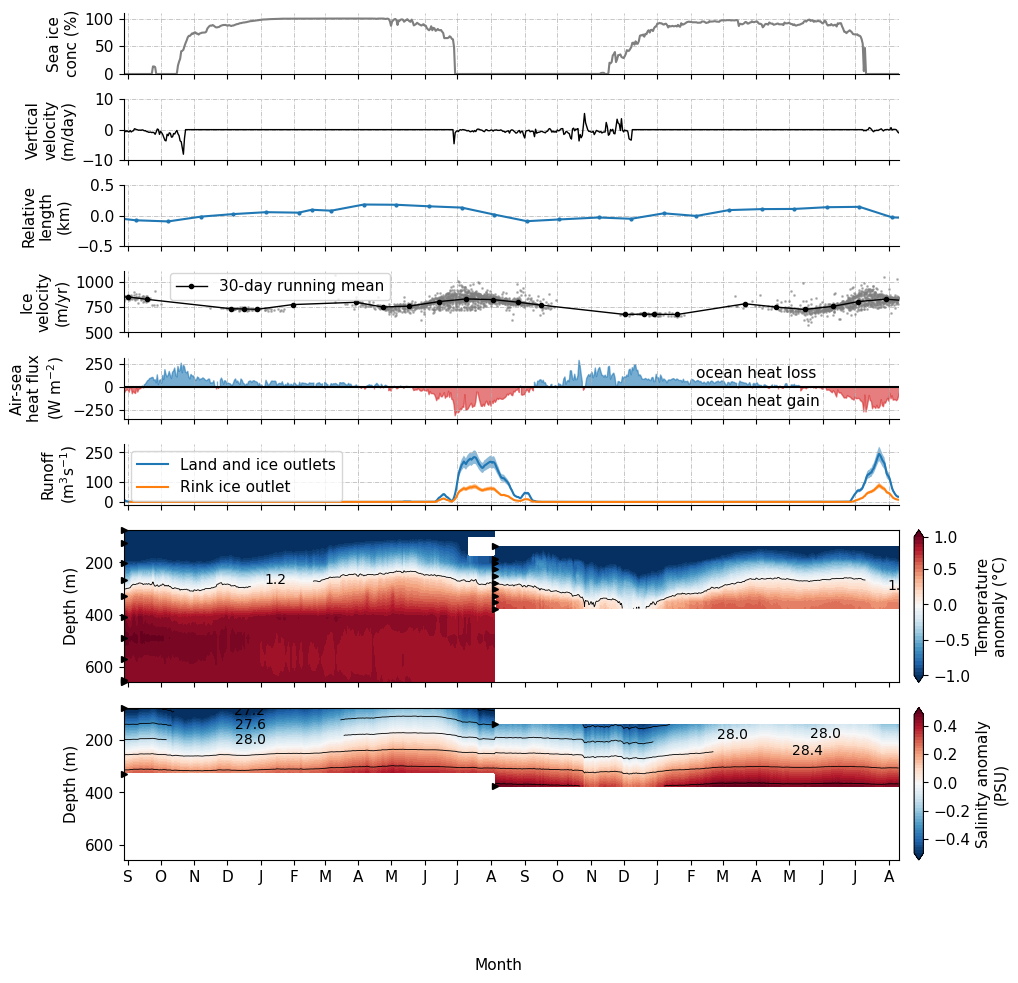

In [172]:
#### set up figure with subplots #### =================================
plt.rcParams['font.size'] = '11'
fig, axs = plt.subplots(nrows=8, ncols=1, sharex=True, sharey=False, figsize=[10,11],\
                        gridspec_kw={'height_ratios': [0.2,0.2,0.2,0.2,0.2,0.2,0.5,0.5]})
(ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8) = axs.ravel()
plt.subplots_adjust(wspace=0.1, hspace=0.15)

## adjust spacing between subplots
plt.subplots_adjust(hspace=0.3)

## add grid lines to upper 6 panels
for ax in (ax1,ax2,ax3,ax4,ax5,ax6):
    ax.grid(linestyle='-.', linewidth=0.5)

#### plot sea ice #### =================================
(ice_rink.siconc*100).plot(ax=ax1, c='tab:gray')
ax1.margins(y=0)
ax1.set_ylim(0,110)
# ax1.legend()

#### plot vertical velocity #### =================================
ekman_rink.plot(ax=ax2,c='k',linewidth=1)

#### plot glacier length #### =================================
rink_terminus_trunc_da = rink_terminus_da.sel(time=slice("2018-07-10","2020-09-20"))
(rink_terminus_trunc_da-rink_terminus_trunc_da.isel(time=0)).plot(ax=ax3,marker='o', markersize=2)

#### plot ice velocity #### =================================
rink_vel_ds_filter.velocity.plot(ax=ax4,marker='o',linestyle='', markersize=1, alpha=0.5, c='tab:gray')
ax4.plot(ts_rink,runmean_rink, color='k', marker='.', linewidth=1, label='30-day running mean')
ax4.legend(bbox_to_anchor=(0.05, 1.1), loc='upper left')

#### plot air-sea heat flux #### =================================
ax5.fill_between(Q_net_watts_rink.time, Q_net_watts_rink.values, 0, where=(Q_net_watts_rink.values>0), color='tab:blue', alpha=0.6)
ax5.fill_between(Q_net_watts_rink.time, Q_net_watts_rink.values, 0, where=(Q_net_watts_rink.values<0), color='tab:red', alpha=0.6)
ax5.axhline(y=0, color='k', linestyle='-')
ax5.text(np.datetime64("2020-02-06"), 100, 'ocean heat loss', fontsize = 11)
ax5.text(np.datetime64("2020-02-06"), -200, 'ocean heat gain', fontsize = 11)

#### plot runoff #### =================================
## plot 7-day running mean for all lang and ice outlets within rink fjord
rink_racmo_7d = rink_racmo_ds.sel(time=slice("2018-07-05","2020-09-10")).discharge.sum(dim=['station','basin_type']).rolling(time=7).mean()
rink_racmo_7d.plot(ax=ax6, label='Land and ice outlets')
## plot for only rink glacier ice outlet
rink_glacier_racmo_7d = rink_racmo_ds.sel(station=30604,time=slice("2018-08-28","2020-08-10")).discharge.sum(dim=['basin_type']).rolling(time=7).mean()
rink_glacier_racmo_7d.plot(ax=ax6, label='Rink ice outlet')
ax6.legend()
# add 15% error
ax6.fill_between(rink_racmo_7d.time.values, rink_racmo_7d+rink_racmo_7d*0.15, rink_racmo_7d-rink_racmo_7d*0.15, alpha=0.5)
ax6.fill_between(rink_glacier_racmo_7d.time.values, rink_glacier_racmo_7d+rink_glacier_racmo_7d*0.15, rink_glacier_racmo_7d-rink_glacier_racmo_7d*0.15, alpha=0.5)

#### plot profiles #### =================================
## set levels
levels_temp=np.arange(-1,1,0.05)
levels_salt=np.arange(-0.5,0.5,0.02)

## plot
temp = (rink_temp_interp_ds.temperature-rink_temp_interp_ds.temperature.mean()).plot.contourf(ax=ax7, cmap='RdBu_r', levels=levels_temp,add_colorbar=False, extend='both')
salt = (rink_salt_interp_ds.salinity-rink_salt_interp_ds.salinity.mean()).plot.contourf(ax=ax8, cmap='RdBu_r',levels=levels_salt,add_colorbar=False, extend='both')

## add isotherm at mean temp value
cs = rink_temp_interp_ds.temperature.plot.contour(ax=ax7,levels=[rink_temp_interp_ds.temperature.mean().values], colors='black', linewidths=0.6)
cl = ax7.clabel(cs, fontsize=10, fmt='%.1f',manual=[(17900,200),(18550,240)])
for l in cl:l.set_rotation(0)

## add potential density contour lines and their labels
cs = rink_dens_interp_ds.density.plot.contour(ax=ax8,colors='black', linewidths=0.6)
manual_locations = [(17900,220),(17900,170),(17900,140),(18400,120),(18400,170),(18400,240)]
cl = ax8.clabel(cs, fontsize=10, inline=True,fmt='%.1f',manual=manual_locations)
for l in cl:l.set_rotation(0)

## add colorbars
axins = inset_axes(ax7,
    width="1.2%",  # width: 5% of parent_bbox width
    height="100%",
    loc="upper left",
    bbox_to_anchor=(1.02, 0., 1, 1),
    bbox_transform=ax7.transAxes,
    borderpad=0)
fig.colorbar(temp,cax=axins,ticks=[-1,-0.5,0,0.5,1],label='Temperature\nanomaly (°C)')
axins = inset_axes(ax8,
    width="1.2%",  # width: 5% of parent_bbox width
    height="100%",
    loc="upper left",
    bbox_to_anchor=(1.02, 0., 1, 1),
    bbox_transform=ax8.transAxes,
    borderpad=0)
fig.colorbar(salt,cax=axins,ticks=[-0.4,-0.2,0,0.2,0.4],label='Salinity anomaly\n(PSU)')

#### adjust axes settings #### =================================
## set limits
ax2.set_ylim(-10,10)
ax3.set_ylim(-0.5,0.5)
ax4.set_ylim(500,1100)
ax7.set_ylim(rink_temp_interp_ds.depth.max(),rink_temp_interp_ds.depth.min())
ax8.set_ylim(rink_salt_interp_ds.depth.max(),rink_salt_interp_ds.depth.min())
ax8.set_xlim([np.datetime64("2018-08-28"),np.datetime64("2020-08-10")])

## add axis labels and ticks
ax1.set_ylabel("Sea ice\nconc (%)")
ax1.set_yticks([0,50,100])
ax2.set_ylabel("Vertical\nvelocity\n(m/day)")
ax2.set_yticks([10,0,-10])
ax3.set_ylabel("Relative\nlength\n(km)")
ax4.set_ylabel("Ice\nvelocity\n(m/yr)")
ax4.set_yticks([500,750,1000])
ax5.set_ylabel("Air-sea\nheat flux\n(W m$^{-2}$)")
ax6.set_ylabel("Runoff\n(m$^3$s$^{-1}$)")
ax6.set_yticks([0,100,250])
ax7.set_ylabel("Depth (m)")
ax8.set_ylabel("Depth (m)")

## lower axis label
months   = pd.period_range(np.datetime64('2018-09'), freq='M', periods=24).strftime('%Y-%m').tolist()
abbrev = ["S","O",'N','D',"J",'F','M','A','M','J','J','A',"S","O",'N','D',"J",'F','M','A','M','J','J','A']
ax8.set_xticks(months, abbrev, rotation=0, horizontalalignment = 'center')
ax8.set_xlabel("")
fig.text(0.5, 0.01, 'Month', size=11, ha='center')

for ax in (ax1,ax2,ax3,ax4,ax5,ax6,ax7):
    ax.set_xlabel("")
    ax.set_title("")
for ax in (ax1,ax2,ax3,ax4,ax5,ax6):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)

#### add sensor depths #### =================================
ax7.plot(list(itertools.repeat(rink_ds.time[0].values-1, len(rink_ds.Depth_temp))), rink_ds.Depth_temp.values,">", color='black', markersize=4, clip_on=False)
ax7.plot(list(itertools.repeat(fisher_ds.time[0].values-1, len(fisher_ds.Depth_temp))), fisher_ds.Depth_temp.values,">", color='black', markersize=4, clip_on=False)

ax8.plot(list(itertools.repeat(rink_ds.time[0].values, len(rink_ds.Depth_CTD))), rink_ds.Depth_CTD.values,">", color='black', markersize=4, clip_on=False)
ax8.plot(list(itertools.repeat(fisher_ds.time[0].values, len(fisher_ds.Depth_CTD))), fisher_ds.Depth_CTD.values,">", color='black', markersize=4, clip_on=False);

plt.savefig("figures/rink-fisher_subplots.png", bbox_inches="tight")

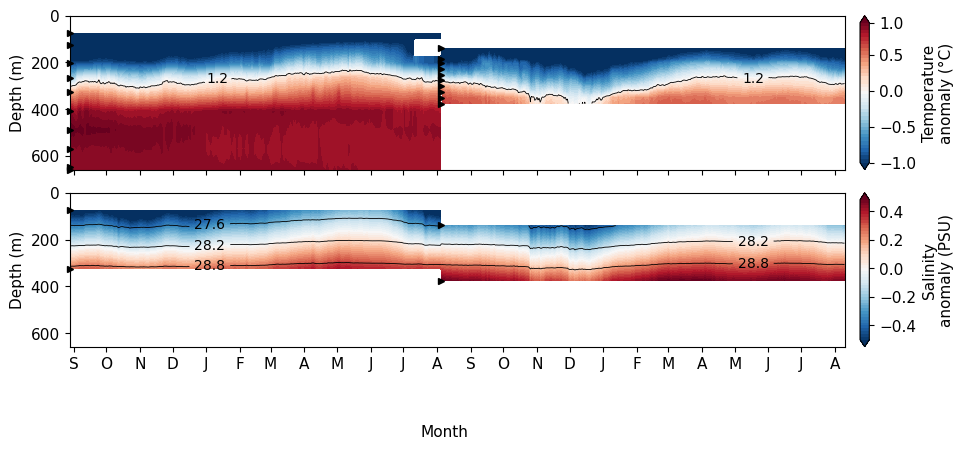

In [181]:
#### set up figure with subplots #### =================================
plt.rcParams['font.size'] = '11'
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=[10,4.3])
(ax1,ax2) = axs.ravel()
plt.subplots_adjust(wspace=0.1, hspace=0.15)

## adjust spacing between subplots
plt.subplots_adjust(hspace=0.15)

#### plot profiles #### =================================
## set levels
levels_temp=np.arange(-1,1,0.05)
levels_salt=np.arange(-0.5,0.5,0.02)

## plot
temp = (rink_temp_interp_ds.temperature-rink_temp_interp_ds.temperature.mean()).plot.contourf(ax=ax1, cmap='RdBu_r', levels=levels_temp,add_colorbar=False, extend='both')
salt = (rink_salt_interp_ds.salinity-rink_salt_interp_ds.salinity.mean()).plot.contourf(ax=ax2, cmap='RdBu_r',levels=levels_salt,add_colorbar=False, extend='both')

## add isotherm at mean temp value
cs = rink_temp_interp_ds.temperature.plot.contour(ax=ax1,levels=[rink_temp_interp_ds.temperature.mean()], colors='black', linewidths=0.6)
cl = ax1.clabel(cs, fontsize=10, fmt='%.1f',manual=[(17900,200),(18400,240)])
for l in cl:l.set_rotation(0)

## add potential density contour lines and their labels
cs = rink_dens_interp_ds.density.plot.contour(ax=ax2,linewidths=0.6, levels=[27.6,28.2,28.8],colors='k')
manual_locations = [(17900,300),(17900,220),(17900,140),(18400,220),(18400,300)]
cl = ax2.clabel(cs, fontsize=10, inline=True,fmt='%.1f',manual=manual_locations)
for l in cl:l.set_rotation(0)

## add colorbars
axins = inset_axes(ax1,
    width="1.2%",  # width: 5% of parent_bbox width
    height="100%",
    loc="upper left",
    bbox_to_anchor=(1.02, 0., 1, 1),
    bbox_transform=ax1.transAxes,
    borderpad=0)
fig.colorbar(temp,cax=axins,ticks=[-1,-0.5,0,0.5,1],label='Temperature\nanomaly (°C)')
axins = inset_axes(ax2,
    width="1.2%",  # width: 5% of parent_bbox width
    height="100%",
    loc="upper left",
    bbox_to_anchor=(1.02, 0., 1, 1),
    bbox_transform=ax2.transAxes,
    borderpad=0)
fig.colorbar(salt,cax=axins,ticks=[-0.4,-0.2,0,0.2,0.4],label='Salinity\nanomaly (PSU)')

#### adjust axes settings #### =================================
## set limits
# ax1.set_ylim(rink_temp_interp_ds.depth.max(),0)
# ax2.set_ylim(rink_salt_interp_ds.depth.max(),0)
ax1.set_ylim(rink_temp_interp_ds.depth.max(),0)
ax2.set_ylim(rink_temp_interp_ds.depth.max(),0)
ax2.set_xlim([np.datetime64("2018-08-28"),np.datetime64("2020-08-10")])

## add axis labels and ticks
ax1.set_ylabel("Depth (m)")
ax2.set_ylabel("Depth (m)")

## lower axis label
months   = pd.period_range(np.datetime64('2018-09'), freq='M', periods=24).strftime('%Y-%m').tolist()
abbrev = ["S","O",'N','D',"J",'F','M','A','M','J','J','A',"S","O",'N','D',"J",'F','M','A','M','J','J','A']
ax2.set_xticks(months, abbrev, rotation=0, horizontalalignment = 'center')
ax2.set_xlabel("")
fig.text(0.5, -0.1, 'Month', size=11, ha='center')

ax1.set_xlabel("")
ax1.set_title("")

#### add sensor depths #### =================================
ax1.plot(list(itertools.repeat(rink_ds.time[0].values-1, len(rink_ds.Depth_temp))), rink_ds.Depth_temp.values,">", color='black', markersize=4, clip_on=False)
ax1.plot(list(itertools.repeat(fisher_ds.time[0].values-1, len(fisher_ds.Depth_temp))), fisher_ds.Depth_temp.values,">", color='black', markersize=4, clip_on=False)

ax2.plot(list(itertools.repeat(rink_ds.time[0].values, len(rink_ds.Depth_CTD))), rink_ds.Depth_CTD.values,">", color='black', markersize=4, clip_on=False)
ax2.plot(list(itertools.repeat(fisher_ds.time[0].values, len(fisher_ds.Depth_CTD))), fisher_ds.Depth_CTD.values,">", color='black', markersize=4, clip_on=False);

plt.savefig("figures/rink-fisher_subplots_profiles_full.png", bbox_inches="tight")

Edited profiles to only look at upper 400 meters <br>
I took the anomaly (i.e., mean) from only these depths

In [144]:
# take mean for upper 400 meters
rink_temp_interp_ds_upper400m_avg = rink_temp_interp_ds.temperature.sel(depth=slice(0,400)).mean()
rink_salt_interp_ds_upper400m_avg = rink_salt_interp_ds.salinity.sel(depth=slice(0,400)).mean()

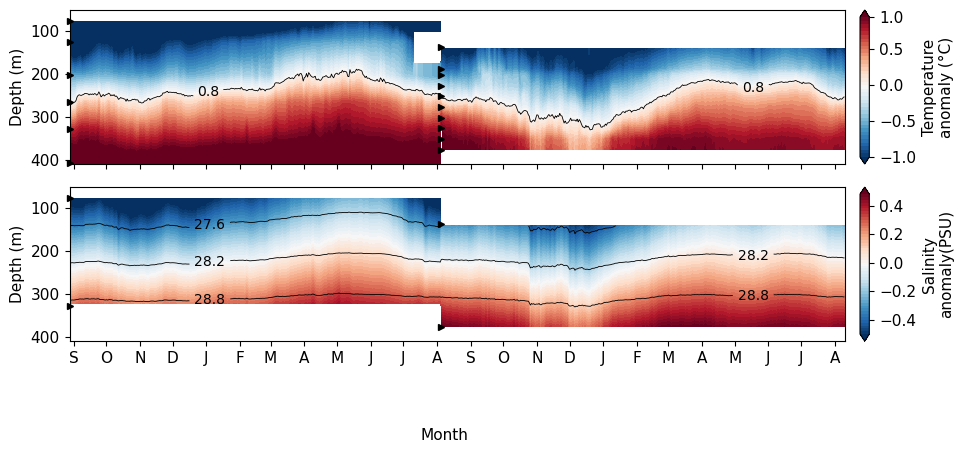

In [183]:
#### set up figure with subplots #### =================================
plt.rcParams['font.size'] = '11'
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=[10,4.3])
(ax1,ax2) = axs.ravel()
plt.subplots_adjust(wspace=0.1, hspace=0.15)

## adjust spacing between subplots
plt.subplots_adjust(hspace=0.15)

#### plot profiles #### =================================
## set levels
levels_temp=np.arange(-1,1,0.05)
levels_salt=np.arange(-0.5,0.5,0.02)

## plot
temp = (rink_temp_interp_ds.temperature-rink_temp_interp_ds_upper400m_avg).plot.contourf(ax=ax1, cmap='RdBu_r', levels=levels_temp,add_colorbar=False, extend='both')
salt = (rink_salt_interp_ds.salinity-rink_salt_interp_ds_upper400m_avg).plot.contourf(ax=ax2, cmap='RdBu_r',levels=levels_salt,add_colorbar=False, extend='both')

## add isotherm at mean temp value
cs = rink_temp_interp_ds.temperature.plot.contour(ax=ax1,levels=[rink_temp_interp_ds_upper400m_avg.values], colors='black', linewidths=0.6)
cl = ax1.clabel(cs, fontsize=10, fmt='%.1f',manual=[(17900,200),(18400,240)])
for l in cl:l.set_rotation(0)

## add potential density contour lines and their labels
cs = rink_dens_interp_ds.density.plot.contour(ax=ax2,linewidths=0.6, levels=[27.6,28.2,28.8],colors='k')
manual_locations = [(17900,300),(17900,220),(17900,140),(18400,220),(18400,300)]
cl = ax2.clabel(cs, fontsize=10, inline=True,fmt='%.1f',manual=manual_locations)
for l in cl:l.set_rotation(0)

## add colorbars
axins = inset_axes(ax1,
    width="1.2%",  # width: 5% of parent_bbox width
    height="100%",
    loc="upper left",
    bbox_to_anchor=(1.02, 0., 1, 1),
    bbox_transform=ax1.transAxes,
    borderpad=0)
fig.colorbar(temp,cax=axins,ticks=[-1,-0.5,0,0.5,1],label='Temperature\nanomaly (°C)')
axins = inset_axes(ax2,
    width="1.2%",  # width: 5% of parent_bbox width
    height="100%",
    loc="upper left",
    bbox_to_anchor=(1.02, 0., 1, 1),
    bbox_transform=ax2.transAxes,
    borderpad=0)
fig.colorbar(salt,cax=axins,ticks=[-0.4,-0.2,0,0.2,0.4],label='Salinity\nanomaly(PSU)')

#### adjust axes settings #### =================================
## set limits
# ax1.set_ylim(rink_temp_interp_ds.depth.max(),0)
# ax2.set_ylim(rink_salt_interp_ds.depth.max(),0)
ax1.set_ylim(410,50)
ax2.set_ylim(410,50)
ax2.set_xlim([np.datetime64("2018-08-28"),np.datetime64("2020-08-10")])

## add axis labels and ticks
ax1.set_ylabel("Depth (m)")
ax2.set_ylabel("Depth (m)")

## lower axis label
months   = pd.period_range(np.datetime64('2018-09'), freq='M', periods=24).strftime('%Y-%m').tolist()
abbrev = ["S","O",'N','D',"J",'F','M','A','M','J','J','A',"S","O",'N','D',"J",'F','M','A','M','J','J','A']
ax2.set_xticks(months, abbrev, rotation=0, horizontalalignment = 'center')
ax2.set_xlabel("")
fig.text(0.5, -0.12, 'Month', size=11, ha='center')

ax1.set_xlabel("")
ax1.set_title("")

#### add sensor depths #### =================================
ax1.plot(list(itertools.repeat(rink_ds.time[0].values-1, len(rink_ds.Depth_temp[0:6]))), rink_ds.Depth_temp.values[0:6],">", color='black', markersize=4, clip_on=False)
ax1.plot(list(itertools.repeat(fisher_ds.time[0].values-1, len(fisher_ds.Depth_temp))), fisher_ds.Depth_temp.values,">", color='black', markersize=4, clip_on=False)

ax2.plot(list(itertools.repeat(rink_ds.time[0].values, len(rink_ds.Depth_CTD))), rink_ds.Depth_CTD.values,">", color='black', markersize=4, clip_on=False)
ax2.plot(list(itertools.repeat(fisher_ds.time[0].values, len(fisher_ds.Depth_CTD))), fisher_ds.Depth_CTD.values,">", color='black', markersize=4, clip_on=False);

plt.savefig("figures/rink-fisher_subplots_profiles.png", bbox_inches="tight")

#### Kong Oscar

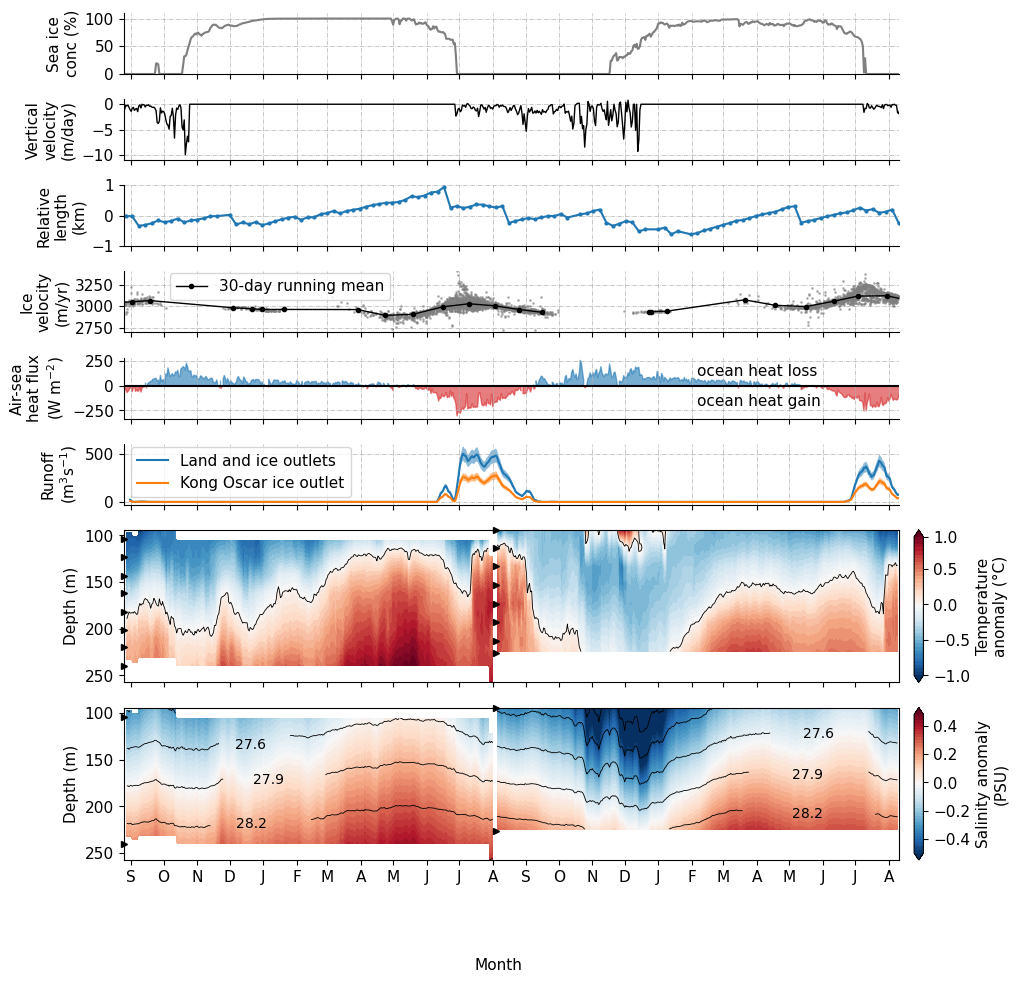

In [168]:
#### set up figure with subplots #### =================================
plt.rcParams['font.size'] = '11'
fig, axs = plt.subplots(nrows=8, ncols=1, sharex=True, sharey=False, figsize=[10,11],\
                        gridspec_kw={'height_ratios': [0.2,0.2,0.2,0.2,0.2,0.2,0.5,0.5]})
(ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8) = axs.ravel()
plt.subplots_adjust(wspace=0.1, hspace=0.15)

## adjust spacing between subplots
plt.subplots_adjust(hspace=0.3)

## add grid lines to upper 6 panels
for ax in (ax1,ax2,ax3,ax4,ax5,ax6):
    ax.grid(linestyle='-.', linewidth=0.5)

#### plot sea ice #### =================================
# (ice_baffinbay_1d_avg.siconc*100).plot(ax=ax1, c='tab:gray', label = "N Baffin Bay")
# (ice_KO.siconc*100).plot(ax=ax1, c='black', label = "Fjord")
(ice_KO.siconc*100).plot(ax=ax1, c='tab:gray')
ax1.margins(y=0)
ax1.set_ylim(0,110)
# ax1.legend()

#### plot vertical velocity #### =================================
ekman_KO.plot(ax=ax2,c='k',linewidth=1)
ax2.set_yticks([0,-5,-10])

#### plot glacier length #### =================================
ko_terminus_trunc_da = ko_terminus_da.sel(time=slice("2018-08-25","2020-08-10"))
(ko_terminus_trunc_da-ko_terminus_trunc_da.isel(time=0)).plot(ax=ax3,marker='o', markersize=2)

#### plot ice velocity #### =================================
ko_vel_ds_filter.velocity.plot(ax=ax4,marker='o',linestyle='', markersize=1, alpha=0.5, c='tab:gray')
ax4.plot(ts_ko,runmean_ko, color='k', marker='.', linewidth=1, label='30-day running mean')
ax4.legend(bbox_to_anchor=(0.05, 1.1), loc='upper left')

#### plot air-sea heat flux #### =================================
ax5.fill_between(Q_net_watts_ko.time, Q_net_watts_ko.values, 0, where=(Q_net_watts_ko.values>0), color='tab:blue', alpha=0.6)
ax5.fill_between(Q_net_watts_ko.time, Q_net_watts_ko.values, 0, where=(Q_net_watts_ko.values<0), color='tab:red', alpha=0.6)
ax5.axhline(y=0, color='k', linestyle='-')
ax5.text(np.datetime64("2020-02-06"), 100, 'ocean heat loss', fontsize = 11)
ax5.text(np.datetime64("2020-02-06"), -200, 'ocean heat gain', fontsize = 11)

#### plot runoff #### =================================
## plot 7-day running mean for all lang and ice outlets within KO fjord
KO_racmo_7d = KO_racmo_ds.sel(time=slice("2018-08-25","2020-08-10")).discharge.sum(dim=['station','basin_type']).rolling(time=7).mean()
KO_racmo_7d.plot(ax=ax6, label='Land and ice outlets')
## plot for only KO glacier ice outlet
KO_glacier_racmo_7d = KO_racmo_ds.sel(station=31202,time=slice("2018-08-25","2020-08-10")).discharge.sum(dim=['basin_type']).rolling(time=7).mean()
KO_glacier_racmo_7d.plot(ax=ax6, label='Kong Oscar ice outlet')
ax6.legend()
# add 15% error
ax6.fill_between(KO_racmo_7d.time.values, KO_racmo_7d+KO_racmo_7d*0.15, KO_racmo_7d-KO_racmo_7d*0.15, alpha=0.5)
ax6.fill_between(KO_glacier_racmo_7d.time.values, KO_glacier_racmo_7d+KO_glacier_racmo_7d*0.15, KO_glacier_racmo_7d-KO_glacier_racmo_7d*0.15, alpha=0.5)

#### plot profiles #### =================================
## set levels
levels_temp=np.arange(-1,1,0.05)
levels_salt=np.arange(-0.5,0.5,0.02)

## plot
temp = (KO_temp_interp_ds.temperature-KO_temp_interp_ds.temperature.mean()).plot.contourf(ax=ax7, cmap='RdBu_r', levels=levels_temp,add_colorbar=False, extend='both')
salt = (KO_salt_interp_ds.salinity-KO_salt_interp_ds.salinity.mean()).plot.contourf(ax=ax8, cmap='RdBu_r',levels=levels_salt,add_colorbar=False, extend='both')

## add isotherm at mean temp value
cs = KO_temp_interp_ds.temperature.plot.contour(ax=ax7,levels=[KO_temp_interp_ds.temperature.mean().values], colors='black', linewidths=0.6)
# cl = ax7.clabel(cs, fontsize=10, fmt='%.1f',manual=[(17900,200),(18550,240)])
for l in cl:l.set_rotation(0)

## add potential density contour lines and their labels
cs = KO_dens_interp_ds.density.plot.contour(ax=ax8,colors='black', linewidths=0.6)
manual_locations = [(17900,220),(17900,170),(17900,140),(18400,120),(18400,170),(18400,240)]
cl = ax8.clabel(cs, fontsize=10, inline=True,fmt='%.1f',manual=manual_locations)
for l in cl:l.set_rotation(0)

## add colorbars
axins = inset_axes(ax7,
    width="1.2%",  # width: 5% of parent_bbox width
    height="100%",
    loc="upper left",
    bbox_to_anchor=(1.02, 0., 1, 1),
    bbox_transform=ax7.transAxes,
    borderpad=0)
fig.colorbar(temp,cax=axins,ticks=[-1,-0.5,0,0.5,1],label='Temperature\nanomaly (°C)')
axins = inset_axes(ax8,
    width="1.2%",  # width: 5% of parent_bbox width
    height="100%",
    loc="upper left",
    bbox_to_anchor=(1.02, 0., 1, 1),
    bbox_transform=ax8.transAxes,
    borderpad=0)
fig.colorbar(salt,cax=axins,ticks=[-0.4,-0.2,0,0.2,0.4],label='Salinity anomaly\n(PSU)')

#### adjust axes settings #### =================================
## set limits
ax2.set_ylim(-11,1)
ax3.set_ylim(-1,1)
ax4.set_ylim(2700,3400)
ax7.set_ylim(KO_temp_interp_ds.depth.max(),KO_temp_interp_ds.depth.min())
ax8.set_ylim(KO_salt_interp_ds.depth.max(),KO_salt_interp_ds.depth.min())
ax8.set_xlim([np.datetime64("2018-08-25"),np.datetime64("2020-08-10")])

## add axis labels and ticks
ax1.set_ylabel("Sea ice\nconc (%)")
ax1.set_yticks([0,50,100])
ax2.set_ylabel("Vertical\nvelocity\n(m/day)")
ax3.set_ylabel("Relative\nlength\n(km)")
ax4.set_ylabel("Ice\nvelocity\n(m/yr)")
ax5.set_ylabel("Air-sea\nheat flux\n(W m$^{-2}$)")
ax6.set_ylabel("Runoff\n(m$^3$s$^{-1}$)")
ax7.set_ylabel("Depth (m)")
ax8.set_ylabel("Depth (m)")

## lower axis label
months   = pd.period_range(np.datetime64('2018-09'), freq='M', periods=24).strftime('%Y-%m').tolist()
abbrev = ["S","O",'N','D',"J",'F','M','A','M','J','J','A',"S","O",'N','D',"J",'F','M','A','M','J','J','A']
ax8.set_xticks(months, abbrev, rotation=0, horizontalalignment = 'center')
ax8.set_xlabel("")
fig.text(0.5, 0.01, 'Month', size=11, ha='center')

for ax in (ax1,ax2,ax3,ax4,ax5,ax6,ax7):
    ax.set_xlabel("")
    ax.set_title("")
for ax in (ax1,ax2,ax3,ax4,ax5,ax6):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)

#### add sensor depths #### =================================
ax7.plot(list(itertools.repeat(kongoscar19.time[0].values-1, len(kongoscar19.Depth_temp))), kongoscar19.Depth_temp.values,">", color='black', markersize=4, clip_on=False)
ax7.plot(list(itertools.repeat(kongoscar20.time[0].values-1, len(kongoscar20.Depth_temp))), kongoscar20.Depth_temp.values,">", color='black', markersize=4, clip_on=False)

ax8.plot(list(itertools.repeat(kongoscar19.time[0].values, len(kongoscar19.Depth_CTD))), kongoscar19.Depth_CTD.values,">", color='black', markersize=4, clip_on=False)
ax8.plot(list(itertools.repeat(kongoscar20.time[0].values, len(kongoscar20.Depth_CTD))), kongoscar20.Depth_CTD.values,">", color='black', markersize=4, clip_on=False);

plt.savefig("figures/kong-oscar_subplots.png", bbox_inches="tight")

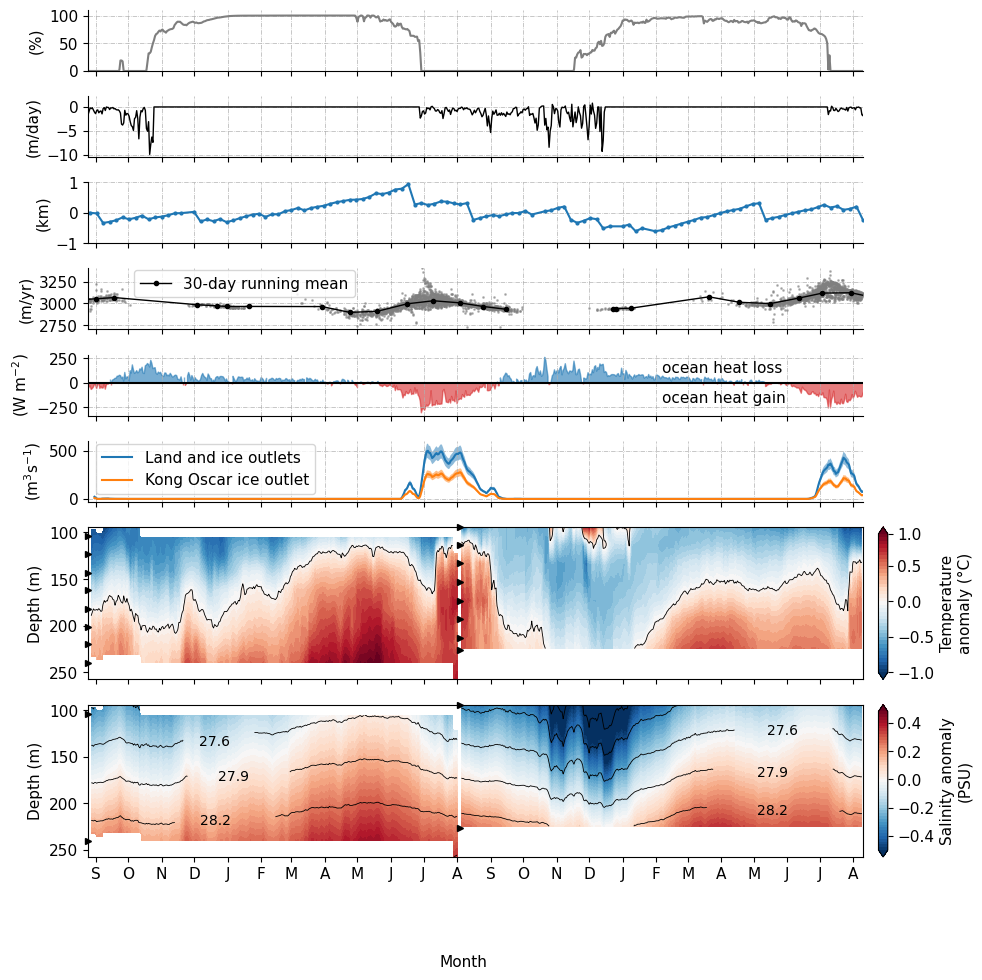

In [151]:
#### set up figure with subplots #### =================================
plt.rcParams['font.size'] = '11'
fig, axs = plt.subplots(nrows=8, ncols=1, sharex=True, sharey=False, figsize=[10,11],\
                        gridspec_kw={'height_ratios': [0.2,0.2,0.2,0.2,0.2,0.2,0.5,0.5]})
(ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8) = axs.ravel()
plt.subplots_adjust(wspace=0.1, hspace=0.15)

## adjust spacing between subplots
plt.subplots_adjust(hspace=0.3)

## add grid lines to upper 6 panels
for ax in (ax1,ax2,ax3,ax4,ax5,ax6):
    ax.grid(linestyle='-.', linewidth=0.5)

#### plot sea ice #### =================================
# (ice_baffinbay_1d_avg.siconc*100).plot(ax=ax1, c='tab:gray', label = "N Baffin Bay")
# (ice_KO.siconc*100).plot(ax=ax1, c='black', label = "Fjord")
(ice_KO.siconc*100).plot(ax=ax1, c='tab:gray')
ax1.margins(y=0)
ax1.set_ylim(0,110)
# ax1.legend()

#### plot vertical velocity #### =================================
ekman_KO.plot(ax=ax2,c='k',linewidth=1)
ax2.set_yticks([0,-5,-10])

#### plot glacier length #### =================================
ko_terminus_trunc_da = ko_terminus_da.sel(time=slice("2018-08-25","2020-08-10"))
(ko_terminus_trunc_da-ko_terminus_trunc_da.isel(time=0)).plot(ax=ax3,marker='o', markersize=2)

#### plot ice velocity #### =================================
ko_vel_ds_filter.velocity.plot(ax=ax4,marker='o',linestyle='', markersize=1, alpha=0.5, c='tab:gray')
ax4.plot(ts_ko,runmean_ko, color='k', marker='.', linewidth=1, label='30-day running mean')
ax4.legend(bbox_to_anchor=(0.05, 1.1), loc='upper left')

#### plot air-sea heat flux #### =================================
ax5.fill_between(Q_net_watts_ko.time, Q_net_watts_ko.values, 0, where=(Q_net_watts_ko.values>0), color='tab:blue', alpha=0.6)
ax5.fill_between(Q_net_watts_ko.time, Q_net_watts_ko.values, 0, where=(Q_net_watts_ko.values<0), color='tab:red', alpha=0.6)
ax5.axhline(y=0, color='k', linestyle='-')
ax5.text(np.datetime64("2020-02-06"), 100, 'ocean heat loss', fontsize = 11)
ax5.text(np.datetime64("2020-02-06"), -200, 'ocean heat gain', fontsize = 11)

#### plot runoff #### =================================
## plot 7-day running mean for all lang and ice outlets within KO fjord
KO_racmo_7d = KO_racmo_ds.sel(time=slice("2018-08-25","2020-08-10")).discharge.sum(dim=['station','basin_type']).rolling(time=7).mean()
KO_racmo_7d.plot(ax=ax6, label='Land and ice outlets')
## plot for only KO glacier ice outlet
KO_glacier_racmo_7d = KO_racmo_ds.sel(station=31202,time=slice("2018-08-25","2020-08-10")).discharge.sum(dim=['basin_type']).rolling(time=7).mean()
KO_glacier_racmo_7d.plot(ax=ax6, label='Kong Oscar ice outlet')
ax6.legend()
# add 15% error
ax6.fill_between(KO_racmo_7d.time.values, KO_racmo_7d+KO_racmo_7d*0.15, KO_racmo_7d-KO_racmo_7d*0.15, alpha=0.5)
ax6.fill_between(KO_glacier_racmo_7d.time.values, KO_glacier_racmo_7d+KO_glacier_racmo_7d*0.15, KO_glacier_racmo_7d-KO_glacier_racmo_7d*0.15, alpha=0.5)

#### plot profiles #### =================================
## set levels
levels_temp=np.arange(-1,1,0.05)
levels_salt=np.arange(-0.5,0.5,0.02)

## plot
temp = (KO_temp_interp_ds.temperature-KO_temp_interp_ds.temperature.mean()).plot.contourf(ax=ax7, cmap='RdBu_r', levels=levels_temp,add_colorbar=False, extend='both')
salt = (KO_salt_interp_ds.salinity-KO_salt_interp_ds.salinity.mean()).plot.contourf(ax=ax8, cmap='RdBu_r',levels=levels_salt,add_colorbar=False, extend='both')

## add isotherm at mean temp value
cs = KO_temp_interp_ds.temperature.plot.contour(ax=ax7,levels=[KO_temp_interp_ds.temperature.mean().values], colors='black', linewidths=0.6)
# cl = ax7.clabel(cs, fontsize=10, fmt='%.1f',manual=[(17900,200),(18550,240)])
for l in cl:l.set_rotation(0)

## add potential density contour lines and their labels
cs = KO_dens_interp_ds.density.plot.contour(ax=ax8,colors='black', linewidths=0.6)
manual_locations = [(17900,220),(17900,170),(17900,140),(18400,120),(18400,170),(18400,240)]
cl = ax8.clabel(cs, fontsize=10, inline=True,fmt='%.1f',manual=manual_locations)
for l in cl:l.set_rotation(0)

## add colorbars
axins = inset_axes(ax7,
    width="1.2%",  # width: 5% of parent_bbox width
    height="100%",
    loc="upper left",
    bbox_to_anchor=(1.02, 0., 1, 1),
    bbox_transform=ax7.transAxes,
    borderpad=0)
fig.colorbar(temp,cax=axins,ticks=[-1,-0.5,0,0.5,1],label='Temperature\nanomaly (°C)')
axins = inset_axes(ax8,
    width="1.2%",  # width: 5% of parent_bbox width
    height="100%",
    loc="upper left",
    bbox_to_anchor=(1.02, 0., 1, 1),
    bbox_transform=ax8.transAxes,
    borderpad=0)
fig.colorbar(salt,cax=axins,ticks=[-0.4,-0.2,0,0.2,0.4],label='Salinity anomaly\n(PSU)')

#### adjust axes settings #### =================================
## set limits
ax3.set_ylim(-1,1)
ax4.set_ylim(2700,3400)
ax7.set_ylim(KO_temp_interp_ds.depth.max(),KO_temp_interp_ds.depth.min())
ax8.set_ylim(KO_salt_interp_ds.depth.max(),KO_salt_interp_ds.depth.min())
ax8.set_xlim([np.datetime64("2018-08-25"),np.datetime64("2020-08-10")])

## add axis labels and ticks
ax1.set_ylabel("(%)")
ax1.set_yticks([0,50,100])
ax2.set_ylabel("(m/day)")
ax3.set_ylabel("(km)")
ax4.set_ylabel("(m/yr)")
ax5.set_ylabel("(W m$^{-2}$)")
ax6.set_ylabel("(m$^3$s$^{-1}$)")
ax7.set_ylabel("Depth (m)")
ax8.set_ylabel("Depth (m)")

## lower axis label
months   = pd.period_range(np.datetime64('2018-09'), freq='M', periods=24).strftime('%Y-%m').tolist()
abbrev = ["S","O",'N','D',"J",'F','M','A','M','J','J','A',"S","O",'N','D',"J",'F','M','A','M','J','J','A']
ax8.set_xticks(months, abbrev, rotation=0, horizontalalignment = 'center')
ax8.set_xlabel("")
fig.text(0.5, 0.01, 'Month', size=11, ha='center')

for ax in (ax1,ax2,ax3,ax4,ax5,ax6,ax7):
    ax.set_xlabel("")
    ax.set_title("")
for ax in (ax1,ax2,ax3,ax4,ax5,ax6):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)

#### add sensor depths #### =================================
ax7.plot(list(itertools.repeat(kongoscar19.time[0].values-1, len(kongoscar19.Depth_temp))), kongoscar19.Depth_temp.values,">", color='black', markersize=4, clip_on=False)
ax7.plot(list(itertools.repeat(kongoscar20.time[0].values-1, len(kongoscar20.Depth_temp))), kongoscar20.Depth_temp.values,">", color='black', markersize=4, clip_on=False)

ax8.plot(list(itertools.repeat(kongoscar19.time[0].values, len(kongoscar19.Depth_CTD))), kongoscar19.Depth_CTD.values,">", color='black', markersize=4, clip_on=False)
ax8.plot(list(itertools.repeat(kongoscar20.time[0].values, len(kongoscar20.Depth_CTD))), kongoscar20.Depth_CTD.values,">", color='black', markersize=4, clip_on=False);

plt.savefig("figures/kong-oscar_subplots_ppt.png", bbox_inches="tight", dpi=300)

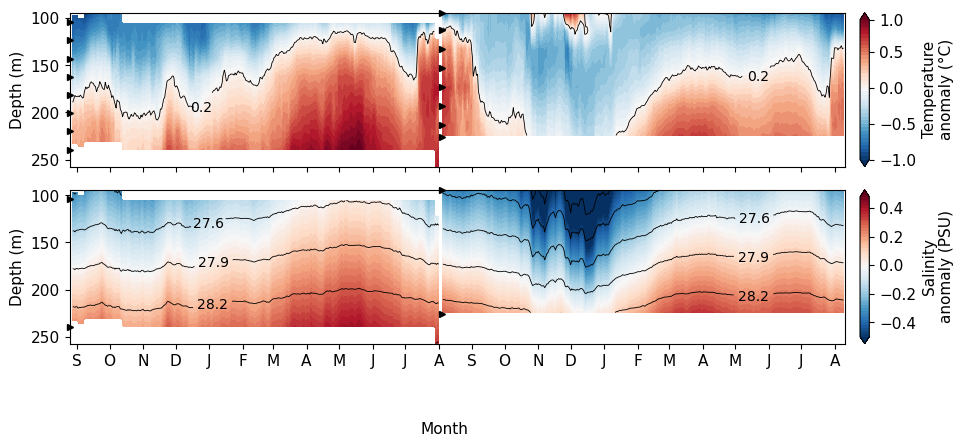

In [155]:
#### set up figure with subplots #### =================================
plt.rcParams['font.size'] = '11'
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=[10,4.3])
plt.subplots_adjust(wspace=0.1, hspace=0.1)

## adjust spacing between subplots
plt.subplots_adjust(hspace=0.15)

temp = (KO_temp_interp_ds.temperature-KO_temp_interp_ds.temperature.mean()).plot.contourf(ax=ax1,cmap='RdBu_r', levels=levels_temp,add_colorbar=False, extend='both')
salt = (KO_salt_interp_ds.salinity-KO_salt_interp_ds.salinity.mean()).plot.contourf(ax=ax2,cmap='RdBu_r',levels=levels_salt,add_colorbar=False, extend='both')

## add isotherm at mean temp value
cs = KO_temp_interp_ds.temperature.plot.contour(ax=ax1,levels=[KO_temp_interp_ds.temperature.mean().values], colors='black', linewidths=0.6)
cl = ax1.clabel(cs, fontsize=10, fmt='%.1f',inline_spacing=9, manual=[(17900,200),(18400,240)])
for l in cl:l.set_rotation(0)

## add potential density contour lines and their labels
cs = KO_dens_interp_ds.density.plot.contour(ax=ax2,colors='black', linewidths=0.6)
manual_locations = [(17900,220),(17900,170),(17900,140),(18400,120),(18400,170),(18400,240)]
cl = ax2.clabel(cs, fontsize=10, inline=True,fmt='%.1f',manual=manual_locations)
for l in cl:l.set_rotation(0)

ax1.set_ylim(KO_temp_interp_ds.depth.max(),KO_temp_interp_ds.depth.min())
ax2.set_ylim(KO_salt_interp_ds.depth.max(),KO_salt_interp_ds.depth.min())
ax2.set_xlim([np.datetime64("2018-08-25"),np.datetime64("2020-08-10")])

ax1.set_ylabel("Depth (m)")
ax2.set_ylabel("Depth (m)")

#### add sensor depths #### =================================
ax1.plot(list(itertools.repeat(kongoscar19.time[0].values-1, len(kongoscar19.Depth_temp))), kongoscar19.Depth_temp.values,">", color='black', markersize=4, clip_on=False)
ax1.plot(list(itertools.repeat(kongoscar20.time[0].values-1, len(kongoscar20.Depth_temp))), kongoscar20.Depth_temp.values,">", color='black', markersize=4, clip_on=False)

ax2.plot(list(itertools.repeat(kongoscar19.time[0].values, len(kongoscar19.Depth_CTD))), kongoscar19.Depth_CTD.values,">", color='black', markersize=4, clip_on=False)
ax2.plot(list(itertools.repeat(kongoscar20.time[0].values, len(kongoscar20.Depth_CTD))), kongoscar20.Depth_CTD.values,">", color='black', markersize=4, clip_on=False);

## lower axis label
months   = pd.period_range(np.datetime64('2018-09'), freq='M', periods=24).strftime('%Y-%m').tolist()
abbrev = ["S","O",'N','D',"J",'F','M','A','M','J','J','A',"S","O",'N','D',"J",'F','M','A','M','J','J','A']
ax2.set_xticks(months, abbrev, rotation=0, horizontalalignment = 'center')
ax2.set_xlabel("")
ax1.set_xlabel("")

## add colorbars
axins = inset_axes(ax1,
    width="1.2%",  # width: 5% of parent_bbox width
    height="100%",
    loc="upper left",
    bbox_to_anchor=(1.02, 0., 1, 1),
    bbox_transform=ax1.transAxes,
    borderpad=0)
fig.colorbar(temp,cax=axins,ticks=[-1,-0.5,0,0.5,1],label='Temperature\nanomaly (°C)')
axins = inset_axes(ax2,
    width="1.2%",  # width: 5% of parent_bbox width
    height="100%",
    loc="upper left",
    bbox_to_anchor=(1.02, 0., 1, 1),
    bbox_transform=ax2.transAxes,
    borderpad=0)
fig.colorbar(salt,cax=axins,ticks=[-0.4,-0.2,0,0.2,0.4],label='Salinity\nanomaly (PSU)');

fig.text(0.5, -0.1, 'Month', size=11, ha='center')

plt.savefig("figures/kong-oscar_subplots_profiles.png", bbox_inches="tight", dpi=300)

#### Sverdrup

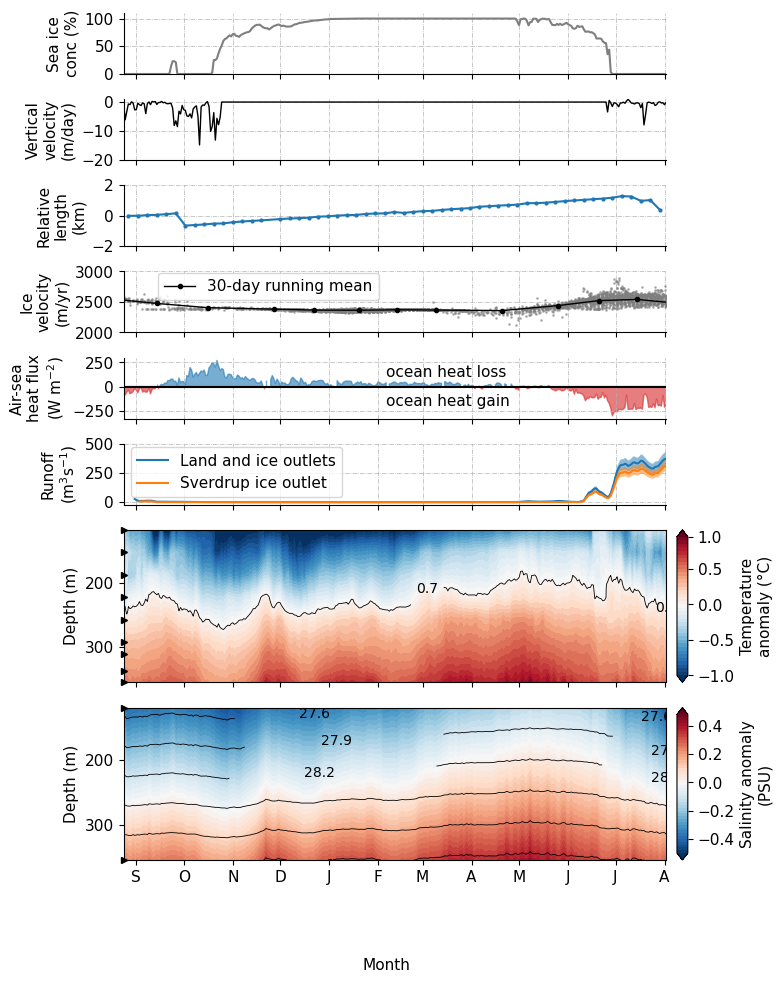

In [169]:
#### set up figure with subplots #### =================================
plt.rcParams['font.size'] = '11'
fig, axs = plt.subplots(nrows=8, ncols=1, sharex=True, sharey=False, figsize=[7,11],\
                        gridspec_kw={'height_ratios': [0.2,0.2,0.2,0.2,0.2,0.2,0.5,0.5]})
(ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8) = axs.ravel()
plt.subplots_adjust(wspace=0.1, hspace=0.15)

## adjust spacing between subplots
plt.subplots_adjust(hspace=0.3)

## add grid lines to upper 6 panels
for ax in (ax1,ax2,ax3,ax4,ax5,ax6):
    ax.grid(linestyle='-.', linewidth=0.5)

#### plot sea ice #### =================================
(ice_sver.siconc*100).plot(ax=ax1, c='tab:gray')
ax1.margins(y=0)
ax1.set_ylim(0,110)
# ax1.legend()

#### plot vertical velocity #### =================================
ekman_sver.plot(ax=ax2,c='k',linewidth=1)

#### plot glacier length #### =================================
sver_terminus_trunc_da = sver_terminus_da.sel(time=slice("2018-08-24","2019-08-02"))
(sver_terminus_trunc_da-sver_terminus_trunc_da.isel(time=0)).plot(ax=ax3,marker='o', markersize=2)

#### plot ice velocity #### =================================
sver_vel_ds_filter.velocity.plot(ax=ax4,marker='o',linestyle='', markersize=1, alpha=0.5, c='tab:gray')
ax4.plot(ts_sver,runmean_sver, color='k', marker='.', linewidth=1, label='30-day running mean')
ax4.legend(bbox_to_anchor=(0.05, 1.1), loc='upper left')

#### plot air-sea heat flux #### =================================
ax5.fill_between(Q_net_watts_sver.time, Q_net_watts_sver.values, 0, where=(Q_net_watts_sver.values>0), color='tab:blue', alpha=0.6)
ax5.fill_between(Q_net_watts_sver.time, Q_net_watts_sver.values, 0, where=(Q_net_watts_sver.values<0), color='tab:red', alpha=0.6)
ax5.axhline(y=0, color='k', linestyle='-')
ax5.text(np.datetime64("2019-02-06"), 100, 'ocean heat loss', fontsize = 11)
ax5.text(np.datetime64("2019-02-06"), -200, 'ocean heat gain', fontsize = 11)

#### plot runoff #### =================================
## plot 7-day running mean for all lang and ice outlets within sver fjord
sver_racmo_7d = sver_racmo_ds.sel(time=slice("2018-08-25","2020-08-10")).discharge.sum(dim=['station','basin_type']).rolling(time=7).mean()
sver_racmo_7d.plot(ax=ax6, label='Land and ice outlets')
## plot for only sver glacier ice outlet
sver_glacier_racmo_7d = sver_racmo_ds.sel(station=31992,time=slice("2018-08-28","2020-08-10")).discharge.sum(dim=['basin_type']).rolling(time=7).mean()
sver_glacier_racmo_7d.plot(ax=ax6, label='Sverdrup ice outlet')
ax6.legend()
# add 15% error
ax6.fill_between(sver_racmo_7d.time.values, sver_racmo_7d+sver_racmo_7d*0.15, sver_racmo_7d-sver_racmo_7d*0.15, alpha=0.5)
ax6.fill_between(sver_glacier_racmo_7d.time.values, sver_glacier_racmo_7d+sver_glacier_racmo_7d*0.15, sver_glacier_racmo_7d-sver_glacier_racmo_7d*0.15, alpha=0.5)

#### plot profiles #### =================================
## set levels
levels_temp=np.arange(-1,1,0.05)
levels_salt=np.arange(-0.5,0.5,0.02)

## plot
temp = (sverdrup_temp_interp_ds.temperature-sverdrup_temp_interp_ds.temperature.mean()).plot.contourf(ax=ax7, cmap='RdBu_r', levels=levels_temp,add_colorbar=False, extend='both')
salt = (sverdrup_salt_interp_ds.salinity-sverdrup_salt_interp_ds.salinity.mean()).plot.contourf(ax=ax8, cmap='RdBu_r',levels=levels_salt,add_colorbar=False, extend='both')

## add isotherm at mean temp value
cs = sverdrup_temp_interp_ds.temperature.plot.contour(ax=ax7,levels=[sverdrup_temp_interp_ds.temperature.mean().values], colors='black', linewidths=0.6)
cl = ax7.clabel(cs, fontsize=10, fmt='%.1f',manual=[(17900,200),(18550,240)])
for l in cl:l.set_rotation(0)

## add potential density contour lines and their labels
cs = sverdrup_dens_interp_ds.density.plot.contour(ax=ax8,colors='black', linewidths=0.6)
manual_locations = [(17900,220),(17900,170),(17900,140),(18400,120),(18400,170),(18400,240)]
cl = ax8.clabel(cs, fontsize=10, inline=True,fmt='%.1f',manual=manual_locations)
for l in cl:l.set_rotation(0)

## add colorbars
axins = inset_axes(ax7,
    width="2%",  # width: 5% of parent_bbox width
    height="100%",
    loc="upper left",
    bbox_to_anchor=(1.02, 0., 1, 1),
    bbox_transform=ax7.transAxes,
    borderpad=0)
fig.colorbar(temp,cax=axins,ticks=[-1,-0.5,0,0.5,1],label='Temperature\nanomaly (°C)')
axins = inset_axes(ax8,
    width="2%",  # width: 5% of parent_bbox width
    height="100%",
    loc="upper left",
    bbox_to_anchor=(1.02, 0., 1, 1),
    bbox_transform=ax8.transAxes,
    borderpad=0)
fig.colorbar(salt,cax=axins,ticks=[-0.4,-0.2,0,0.2,0.4],label='Salinity anomaly\n(PSU)')

#### adjust axes settings #### =================================
## set limits
ax2.set_ylim(-20,1)
ax3.set_ylim(-2,2)
ax4.set_ylim(2000,3000)
ax7.set_ylim(sverdrup_temp_interp_ds.depth.max(),sverdrup_temp_interp_ds.depth.min())
ax8.set_ylim(sverdrup_salt_interp_ds.depth.max(),sverdrup_salt_interp_ds.depth.min())

ax1.set_xlim([np.datetime64("2018-08-24"),np.datetime64("2019-08-02")])
ax2.set_xlim([np.datetime64("2018-08-24"),np.datetime64("2019-08-02")])

## add axis labels and ticks
ax1.set_ylabel("Sea ice\nconc (%)")
ax1.set_yticks([0,50,100])
ax2.set_ylabel("Vertical\nvelocity\n(m/day)")
ax2.set_yticks([0,-10,-20])
ax3.set_ylabel("Relative\nlength\n(km)")
ax4.set_ylabel("Ice\nvelocity\n(m/yr)")
ax4.set_yticks([2000,2500,3000])
ax5.set_ylabel("Air-sea\nheat flux\n(W m$^{-2}$)")
ax6.set_ylabel("Runoff\n(m$^3$s$^{-1}$)")
ax6.set_yticks([0,250,500])
ax7.set_ylabel("Depth (m)")
ax8.set_ylabel("Depth (m)")

## lower axis label
months   = pd.period_range(np.datetime64('2018-09'), freq='M', periods=24).strftime('%Y-%m').tolist()
abbrev = ["S","O",'N','D',"J",'F','M','A','M','J','J','A',"S","O",'N','D',"J",'F','M','A','M','J','J','A']
ax8.set_xticks(months, abbrev, rotation=0, horizontalalignment = 'center')
ax8.set_xlabel("")
fig.text(0.5, 0.01, 'Month', size=11, ha='center')

for ax in (ax1,ax2,ax3,ax4,ax5,ax6,ax7):
    ax.set_xlabel("")
    ax.set_title("")
for ax in (ax1,ax2,ax3,ax4,ax5,ax6):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    ax.set_xlim([np.datetime64("2018-08-24"),np.datetime64("2019-08-02")])

#### add sensor depths #### =================================
ax7.plot(list(itertools.repeat(sverdrup_ds.time[0].values-1, len(sverdrup_ds.Depth_temp))), sverdrup_ds.Depth_temp.values,">", color='black', markersize=4, clip_on=False)
ax8.plot(list(itertools.repeat(sverdrup_ds.time[0].values, len(sverdrup_ds.Depth_CTD))), sverdrup_ds.Depth_CTD.values,">", color='black', markersize=4, clip_on=False)

plt.savefig("figures/sverdrup_subplots.png", bbox_inches="tight")

In [104]:
sverdrup_temp_interp_ds

<xarray.Dataset>
Dimensions:      (time: 344, depth: 100)
Coordinates:
  * time         (time) datetime64[ns] 2018-08-24 2018-08-25 ... 2019-08-02
  * depth        (depth) float64 118.0 120.4 122.8 125.2 ... 350.2 352.6 355.0
Data variables:
    temperature  (depth, time) float64 0.3978 0.4378 0.2739 ... 1.288 1.213

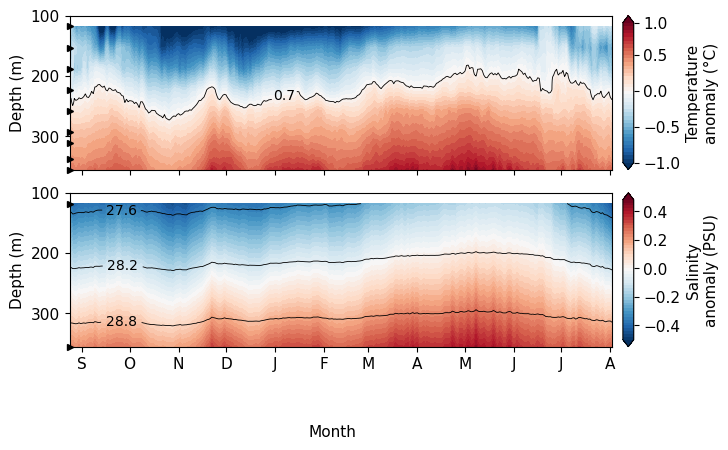

In [156]:
#### set up figure with subplots #### =================================
plt.rcParams['font.size'] = '11'
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=[7,4.3])
(ax1,ax2) = axs.ravel()
plt.subplots_adjust(wspace=0.1, hspace=0.15)

## adjust spacing between subplots
plt.subplots_adjust(hspace=0.15)

#### plot profiles #### =================================
## set levels
levels_temp=np.arange(-1,1,0.05)
levels_salt=np.arange(-0.5,0.5,0.02)

## plot
temp = (sverdrup_temp_interp_ds.temperature-sverdrup_temp_interp_ds.temperature.mean()).plot.contourf(ax=ax1, cmap='RdBu_r', levels=levels_temp,add_colorbar=False, extend='both')
salt = (sverdrup_salt_interp_ds.salinity-sverdrup_salt_interp_ds.salinity.mean()).plot.contourf(ax=ax2, cmap='RdBu_r',levels=levels_salt,add_colorbar=False, extend='both')

## add isotherm at mean temp value
cs = sverdrup_temp_interp_ds.temperature.plot.contour(ax=ax1,levels=[sverdrup_temp_interp_ds.temperature.mean().values], colors='black', linewidths=0.6)
cl = ax1.clabel(cs, fontsize=10, fmt='%.1f',manual=[(17900,200)])
for l in cl:l.set_rotation(0)

## add potential density contour lines and their labels
cs = sverdrup_dens_interp_ds.density.plot.contour(ax=ax2,levels=[27.6,28.2,28.8],colors='k',linewidths=0.6)
manual_locations = [(17800,300),(17800,240),(17800,140)]
cl = ax2.clabel(cs, fontsize=10, inline=True,fmt='%.1f',manual=manual_locations)
for l in cl:l.set_rotation(0)

## add colorbars
axins = inset_axes(ax1,
    width="2%",  # width: 5% of parent_bbox width
    height="100%",
    loc="upper left",
    bbox_to_anchor=(1.02, 0., 1, 1),
    bbox_transform=ax1.transAxes,
    borderpad=0)
fig.colorbar(temp,cax=axins,ticks=[-1,-0.5,0,0.5,1],label='Temperature\nanomaly (°C)')
axins = inset_axes(ax2,
    width="2%",  # width: 5% of parent_bbox width
    height="100%",
    loc="upper left",
    bbox_to_anchor=(1.02, 0., 1, 1),
    bbox_transform=ax2.transAxes,
    borderpad=0)
fig.colorbar(salt,cax=axins,ticks=[-0.4,-0.2,0,0.2,0.4],label='Salinity\nanomaly (PSU)')

#### adjust axes settings #### =================================
## set limits
ax1.set_ylim(sverdrup_temp_interp_ds.depth.max(),100)
ax2.set_ylim(sverdrup_salt_interp_ds.depth.max(),100)

ax1.set_xlim([np.datetime64("2018-08-24"),np.datetime64("2019-08-02")])
ax2.set_xlim([np.datetime64("2018-08-24"),np.datetime64("2019-08-02")])

## add axis labels and ticks
ax1.set_ylabel("Depth (m)")
ax2.set_ylabel("Depth (m)")

## lower axis label
months   = pd.period_range(np.datetime64('2018-09'), freq='M', periods=24).strftime('%Y-%m').tolist()
abbrev = ["S","O",'N','D',"J",'F','M','A','M','J','J','A',"S","O",'N','D',"J",'F','M','A','M','J','J','A']
ax2.set_xticks(months, abbrev, rotation=0, horizontalalignment = 'center')
ax2.set_xlabel("")
fig.text(0.5, -0.1, 'Month', size=11, ha='center')

ax1.set_xlabel("")
ax1.set_title("")
ax1.set_xlim([np.datetime64("2018-08-24"),np.datetime64("2019-08-02")])

#### add sensor depths #### =================================
ax1.plot(list(itertools.repeat(sverdrup_ds.time[0].values-1, len(sverdrup_ds.Depth_temp))), sverdrup_ds.Depth_temp.values,">", color='black', markersize=4, clip_on=False)
ax2.plot(list(itertools.repeat(sverdrup_ds.time[0].values, len(sverdrup_ds.Depth_CTD))), sverdrup_ds.Depth_CTD.values,">", color='black', markersize=4, clip_on=False)

plt.savefig("figures/sverdrup_subplots_profiles.png", bbox_inches="tight")